In [1]:
import random
import imageio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Подготовка датасета

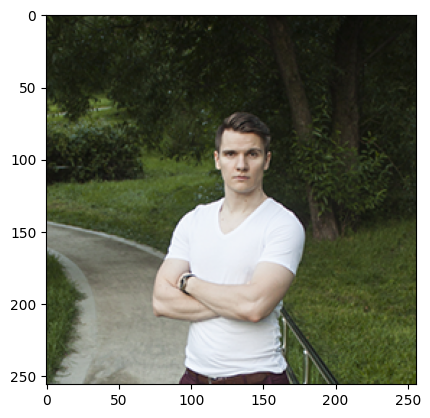

In [3]:
img = imageio.imread_v2('datasets/pics/6.11_me_256.png')
img = img.astype(np.float32) / 255.
_ = plt.imshow(img)

# Загрузка и подготовка карты сегментации человек/фон
То же самое касается файла 'me_gt_256.png'
Это наша Ground-Truth карта сегментации, размеченная кем-то вручную. Значение '0' в ней означает класс "фон", значение '1' - класс
человек

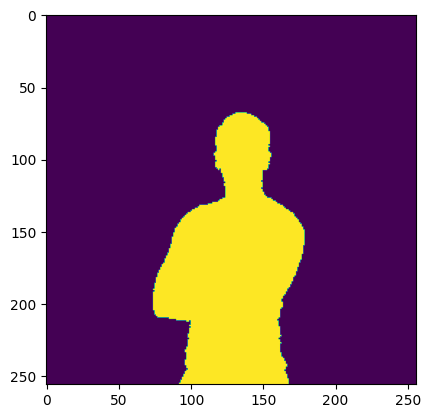

In [4]:
gt = imageio.imread_v2('datasets/pics/6.11_me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]
_ = plt.imshow(gt[..., 0])

# Подготовка обучающего датасета
Наша цель создать пайплайн для обучения FCN модели, включая данные, модель, лосс и т.д.
Поэтому для простоты эксперемента возьмем очень простой датасет, состоящий из двух изображений: загруженная карта и отраженная копия.
Индексирование '::-1' означает взять элементы в обратном порядке.
При обучении на таком маленьком датасете модель переобучится, но в данном примере нас это не будет беспокоить. Наша цель - отладить 
пайплайн, поэтому тестировать будем на этом же датасете, на котором и обучались.

TypeError: imshow() missing 1 required positional argument: 'X'

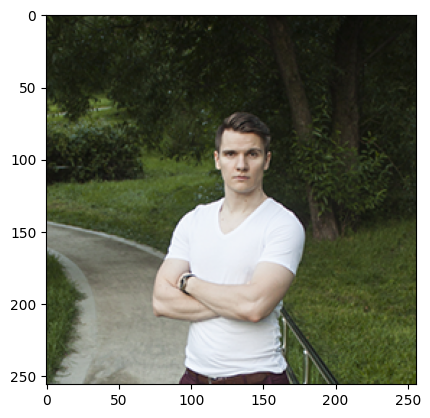

In [7]:
train_x = np.stack((img, img[:, ::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.imshow()
plt.imshow(train_y[0][...,0]), plt.imshow()
plt.imshow(train_x[1]), plt.imshow()
plt.imshow(train_y[1][...,0]), plt.imshow()

In [13]:
import scipy
import numpy as np
from scipy.stats import laplace
laplace.pdf(1.46, 100, 1.65) + 0.5

0.5